## Self Attention Mechanism

### Capturing Data dependencies with attention mechanisms

#### Using RNN's was the traditional way to perfomr machine translation. The problem is that RNN's work fine only for short sentences, they don't work well for longer texts as they don't have direct access to previous words in the input. One major shortcoming in this approach is that the RNN must remember the entire encoded input in a single hidden state before passing it to the decoder.

#### Due to this, researchers developed the Bahdanau attention mechanism for RNN's in 2014, which modifies the encoder-decoder RNN such that the decoder can selectively access parts of the input sequence at each decoding step.

#### Interestingly, only three years later, researchers found that RNN architectures are not required for building deep neural networks for natural language processing and proposed the original transformer architecture including a self-attention mechanism inspired by the Bahdanau attention mechanism.

## Self-Attention

#### Self-attention is a mechanism that allows each position in the input sequence to consider the relevancy of, or "attend to", all other positions in the same sequence when computing the representation of the sequence 

## Attending to different parts of the input with self-attention

#### Since self-attention is a complicated we will begin by coding a simplified version of it that does not contain any trainable weights.

In [2]:
from IPython.display import Image

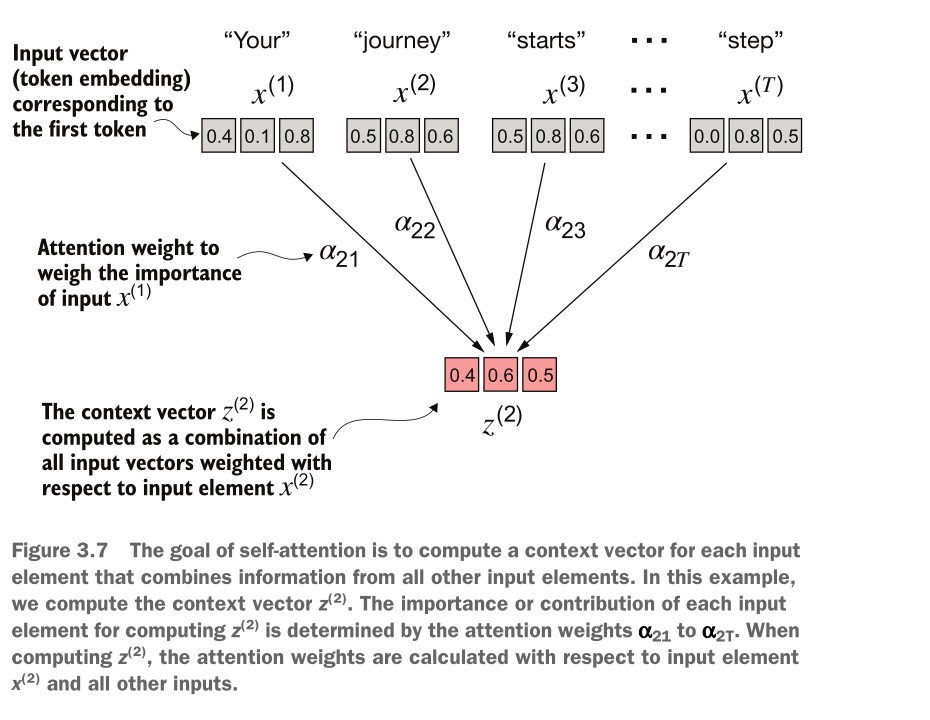

In [3]:
Image(filename='./Screenshot from 2025-05-25 15-32-08.png')

#### The figure above shows an input sequence, denoted as a x, that consists of T elements: $x^1 , \ldots, x^t$. For example, consider an input text like “Your journey starts with one step.” In this case each $x^i$ corresponds to a d-dimensional embedding vector representing a specific token.

#### In self-attention our goal is to calculate context vectors $z^i$ for each $x^i$ in the input sequence. A context vector can be interpreted as an enriched embedding vector. 

#### Context vectors play a crucial role in self-attention. Their purpose is to create representations of each element in an input sequence by incorporating information from all other elements in the sequence. This is essential in LLMs, which need to understand the relationship and relevance of words in a sentence to each other. Later, we will add trainable weights that help an LLM learn to construct these context vectors so that they are relevant for the LLM to generate the next token.


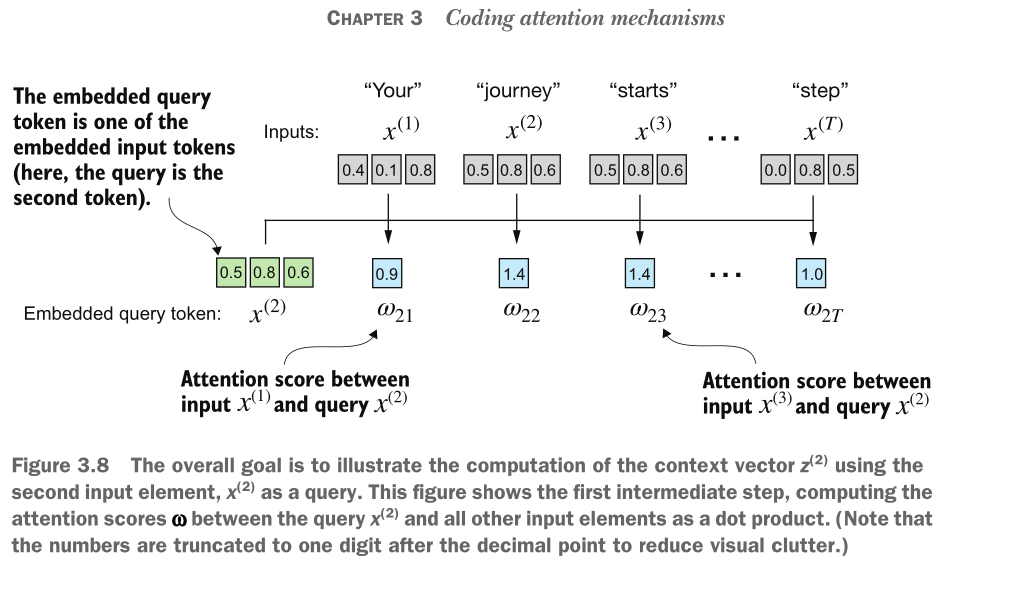

In [4]:
Image(filename='./Screenshot from 2025-05-25 16-09-05.png')

#### The figure above illustrates how we calculate intermediate attention scores between the query token and each input token: we perform a dot product between the embeddings of the query token and the input other input embeddings

#### Consider the example below

In [5]:
import torch

/home/armando-albornoz/Desktop/LLM_Project/env/lib/python3.12/site-packages/torch/_subclasses/functional_tensor.py:276: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:81.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [6]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

In [7]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


#### To build intuition, notice that the dot product can be seen as a measure of similarity between two vectors: a higher dot product means a higher degree of aligment between the vectors. The dot product determines the extent to which each element in a sequence focuses on, or "attends to," any other element: the higher the dot product, the higher the similarity and attention score between two elements.

#### The next step is to normalize the attention scores to obtain the attention weights that sum up to one.

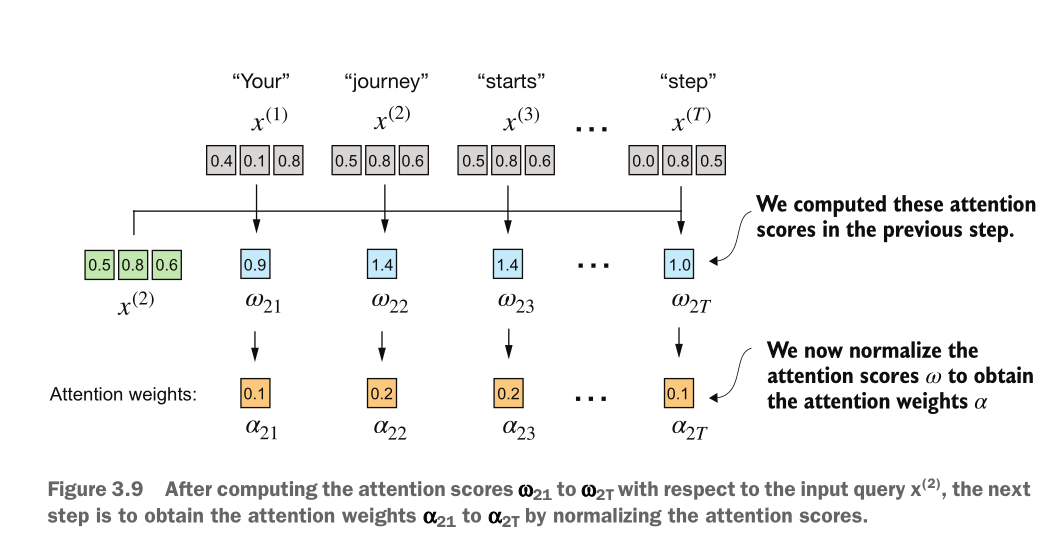

In [8]:
Image(filename='./Screenshot from 2025-05-25 17-14-09.png')

#### This normalization is a convention that is useful for interpretation and maintaining training stability in an LLM. Here’s a straightforward method for achieving this normalization step:

In [9]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In [10]:
# In practice, it’s more common and advisable to use the softmax function for normalization.
# This approach is better at managing extreme values and offers more favorable gradient properties during training.

# In addition, the softmax function ensures that the attention weights are always 
# positive. This makes the output interpretable as probabilities or relative importance,
# where higher weights indicate greater importance.

attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


#### Now we are ready to compute $z^2$ by doing a linear combination of the embedded input tokens scaled by the attention weights.

In [11]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


#### Below is an illustration of the process:

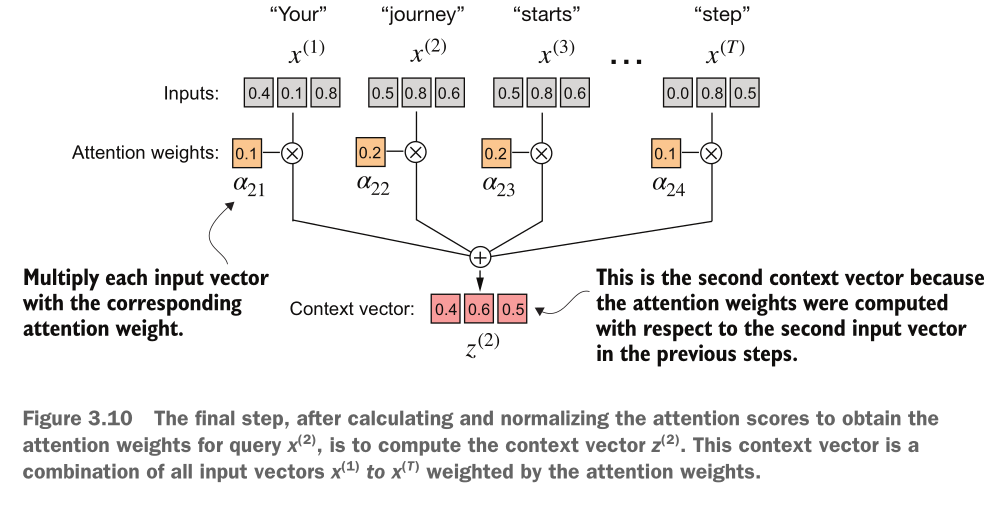

In [12]:
Image(filename='./Screenshot from 2025-05-25 17-29-56.png')

#### Next, we will generalize this procedure for computing context vectors to calculate all context vectors simultaneously.

## Computing attention weights for all input tokens

In [13]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [14]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [15]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## Implementing self-attention with trainable weights

#### We need to introduce a weight matrices that are updated during model training. These matrices are important so that the model can learn to produce "good" context vectors.

#### We will implement this self-attention mechanism step-by-step by introducing the three trainable weight matrices $W_q, W_k, W_v$. These matrices are used to project the embedded input tokens $x^i$,into query, key, and value vectors, respectively, as shown below:

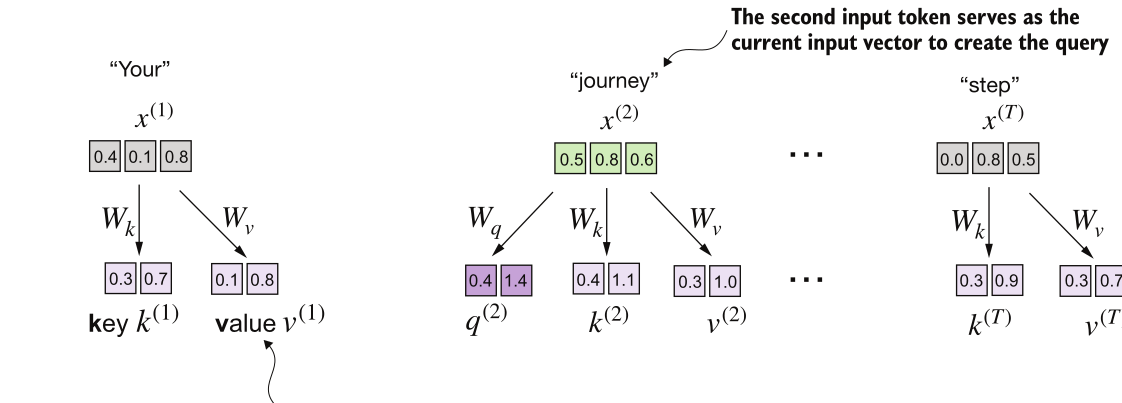

In [16]:
Image(filename='./Screenshot from 2025-05-25 18-22-56.png')

In [17]:
x_2 = inputs[1]
d_in = inputs.shape[1] # The input embedding size d = 3
d_out = 2              # The output embedding size, d_out=2

#### In GPT like models $d_{in} = d_{out}$, but to be able to understand the computatations we let them be different.

In [18]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False) # set requires_grad = True when training
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

print(W_query)

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])


In [19]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


#### Our goal is to compute $z^2$, we still require the key and value vectors for all input elements as they are involved in computing the attention weights with respect to the query $q^2$

In [20]:
# We can obtain all the keys and values via matrix multiplication

keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


#### The second step is to compute the attention scores:

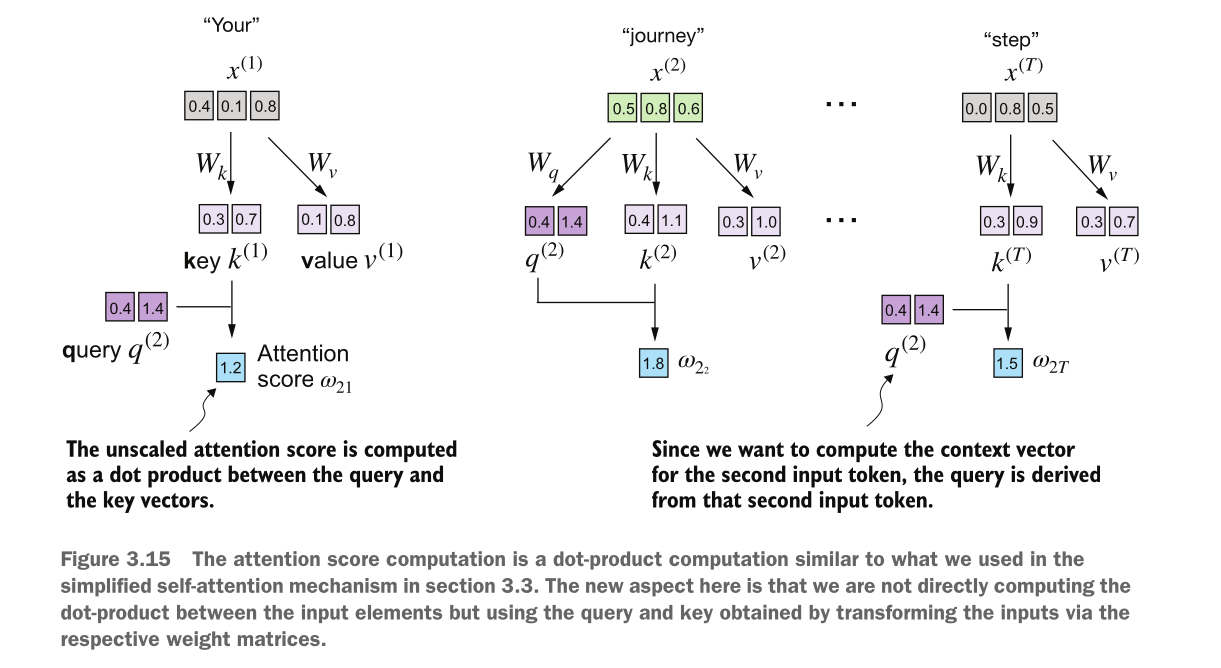

In [21]:
Image(filename='./Screenshot from 2025-05-25 19-02-29.png')

#### Let's compute the attention score $w_{22}$:

In [22]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [23]:
# we can generalize this computation to all attention scores via matrix multiplication
attn_scores_2 =  query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


#### Now, we want to go from the attention scores to the attention weights. We compute the attention weights by scaling the attention scores and using the softmax function. However, now we scale the attention scores by dividing them by the square root of the embedding dimension of the keys

In [24]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim = -1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


#### Now, the final step is to compute the context vectors. Similar to the computation for the context vector as a linear combination of the input vectors, we now compute the context vector as a linaer combination over the value vectors

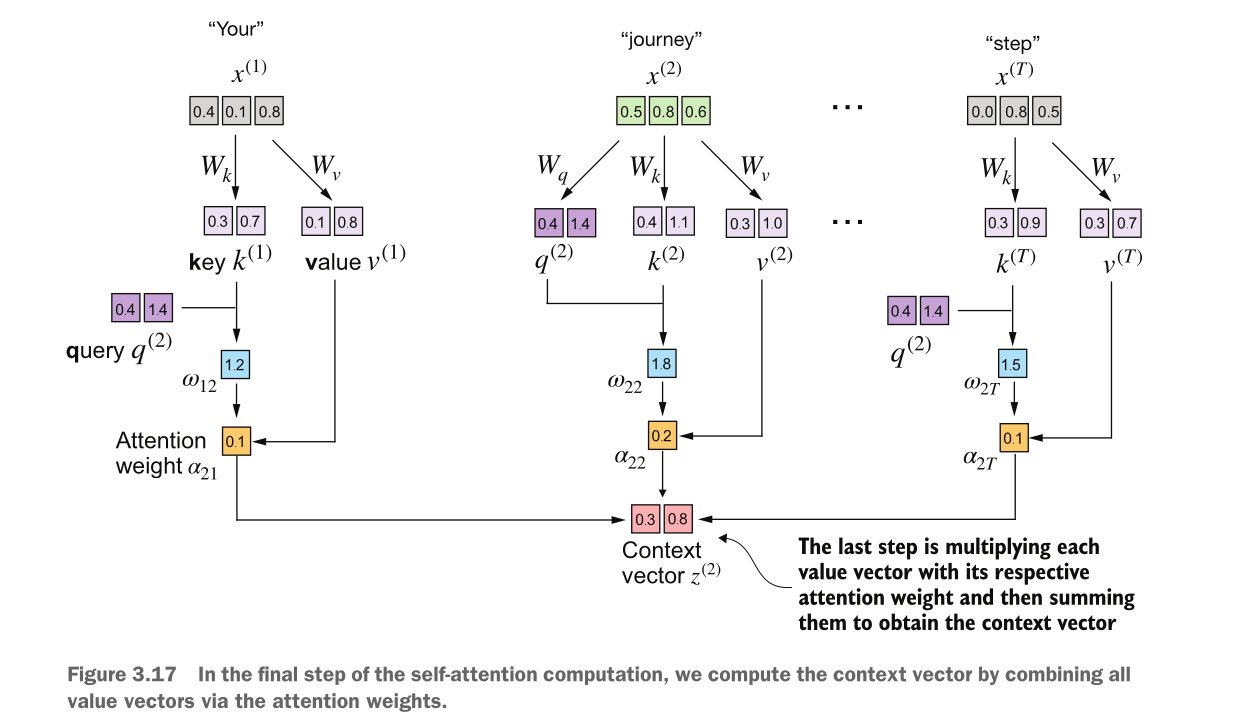

In [25]:
Image('./Screenshot from 2025-05-25 19-35-49.png')

In [27]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


#### Why query, key and value?

#### a query is analogous to a search query in a database. It represents the current item (e.g., a word or token in a sentence) the model focuses on or tries to understand. The query is used to probe the other parts of the input sequence to determine how much attention to pay to them.

#### The key is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key. These keys are used to match the query.

#### The value in this context is similar to the value in a key-value pair in a database. It represents the actual content or representation of the input items. Once the model determines which keys are most relevant to the query, it retrieves the corresponding values.


#### You can also think about it in the following way: Each token in a sentence is trying to look around and decide which other tokens are important to it. To do this, it uses a query, which represents what this token is looking for in the other tokens, a key, which is a representation of what each other token has to offer, it's like a tag or description of what the tokenis about. Fianlly the value is the actual information that will be passed along if the token is attended to.

#### Consider the following example: Suppose we have the sentence  “The cat sat on the mat.”. Let’s say we're processing the word "sat".

#### Query (from "sat") = “What do I need to know to understand ‘sat’?”

#### Keys (from each token):

####  “The”: article

####    “cat”: subject of the sentence (who sat)

####    “on”: preposition

####    “the”: article

####    “mat”: object of preposition

#### Values: The meaning/content of each token.


#### The query from “sat” will match most strongly with the key from “cat”, because the verb “sat” is closely related to its subject “cat”. So the model will attend more to “cat” and maybe also “mat” to understand the full picture.

#### You may ask how does a token know what it wants to know? And the answer is that it does't know in advance. Instead, it learns what to want during training.



## Implementing a compact self-attention Python class

In [28]:
import torch.nn as nn

class SelfAttention_v1 (nn.Module):
    
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))
        
    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax( attn_scores / keys.shape[-1]**0.5, dim=-1 )
        context_vec = attn_weights @ values
        return context_vec

In [29]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


#### We can improve the previous class by using nn.Linear layers, which effectively performs matrix multiplication when the bias units are disabled. Additionally, a significant advantage of using nn.Linear instead of manually implementing nn.Parameter(torch.rand(...)) is that nn.Linear has an optimized weight initialization scheme, contributing to more stable and effective model training.

In [30]:
import torch.nn as nn

class SelfAttention_v2 (nn.Module):
    
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax( attn_scores / keys.shape[-1]**0.5, dim=-1 )
        context_vec = attn_weights @ values
        return context_vec


In [31]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


#### Our goal is now to enhance the self-attention mechanism, focusing on implementing causal and multi-head elements. The causal aspect involves modifying the attention mechanism to prevent the model from accessing future information in the sequence, which is crucial for tasks like language modeling, where each word prediction should only depend on previous words.

#### The multi-head component involves splitting the attention mechanism into multiple "heads" each head learns different aspects of the data, allowing the model to simultaneously attend information from different representation subspaces at different positions. This improves the model’s performance in complex tasks.

## Hiding future words with causal attention

#### For LLMs you wan to consider only the tokens that come before a given tokes in order to to make predictions. Causal attention, also know as masked attention, is a specialized form of self.attention. It restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention scores.

#### To achieve this, we mask out the future tokens, which come after the current token in the input text, as illustrated below:

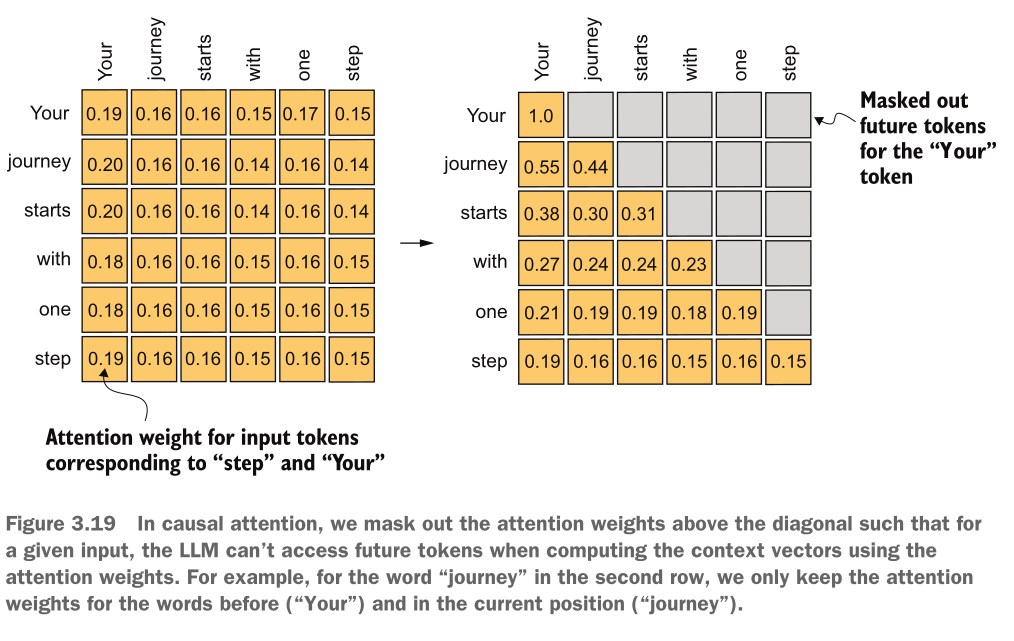

In [32]:
Image(filename='./Screenshot from 2025-05-25 23-08-51.png')

#### In the first step, we compute the attention weights using the softmax function as we have done previously:

In [33]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


#### The next step:  marking the values above the diagonal with zeros can be implemented using the tril function

In [35]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [36]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


####row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm) We now renormalize

In [37]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


#### There is a more efficient way to mask the attention weights and is by masking the attention scores with negative infinity values before applying the softmax function. Since the softmax function converts values into a probabiluty distribution. When negative infinity values are present in a row, the softmax function treats them as zero probability.

In [41]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [42]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


## Masking additional attention weights with dropout

#### Dropout is a technique where randomly selected hidden layer units are ignored during training, effectively dropping them out. This method helps preventing overfitting by ensuring that a model does not become over reliant on any specific set of layer units. It’s important to emphasize that dropout is only used during training and is disabled afterward.

#### In the transformer architecture, including models like GPT, dropout in the attention mechanism is typically applied at two specific times: after calculating the attention weights or after applyign the attention weights to the value vector. Here we will apply the dropout mask after computing the attention weights.

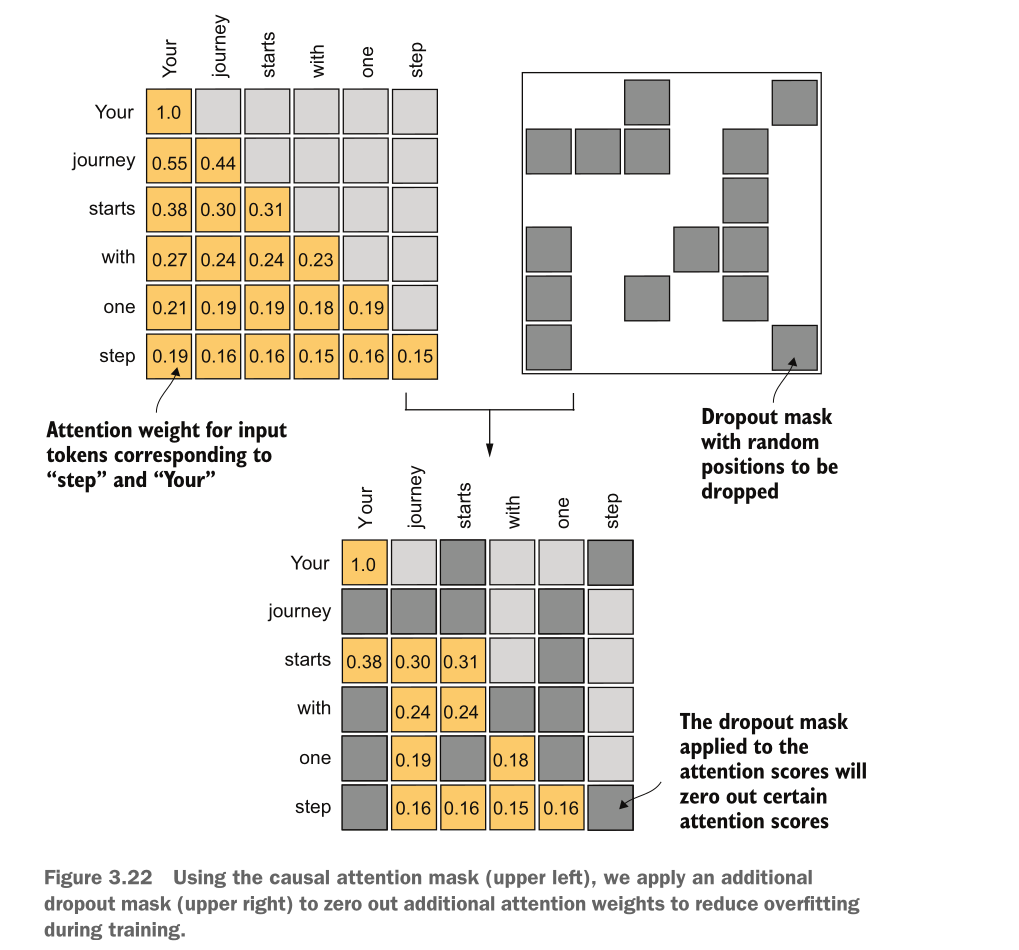

In [43]:
Image('./Screenshot from 2025-05-26 12-18-55.png')

In [44]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # 50 percent dropout
example = torch.ones(6,6) # matrix of ones
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [45]:
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4925, 0.4638, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3941, 0.0000],
        [0.3869, 0.3327, 0.0000, 0.3084, 0.3331, 0.3058]],
       grad_fn=<MulBackward0>)


#### Implementing a compact causal attention class

In [49]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
            b, num_tokens, d_in = x.shape
            keys = self.W_key(x)
            queries = self.W_query(x)
            values = self.W_value(x)

            attn_scores = queries @ keys.transpose(1, 2)
            attn_scores.masked_fill_(
                self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
            attn_weights = torch.softmax(
                attn_scores / keys.shape[-1]**0.5, dim=-1
            )
            attn_weights = self.dropout(attn_weights)
            context_vec = attn_weights @ values
            return context_vec

## Extending single-head attention to multi-head attention

### Stacking multiple single-head attention layers

#### In practical terms implementing, multi-head attention involves creating multiple instances of self-attention mechanism, each with its own weights, adn then combining their outputs. Using multiple instances of the self-attention mechanism can be computationally intensive, but it's crucial for the kind of complex pattern recognition models like GPT are known for.

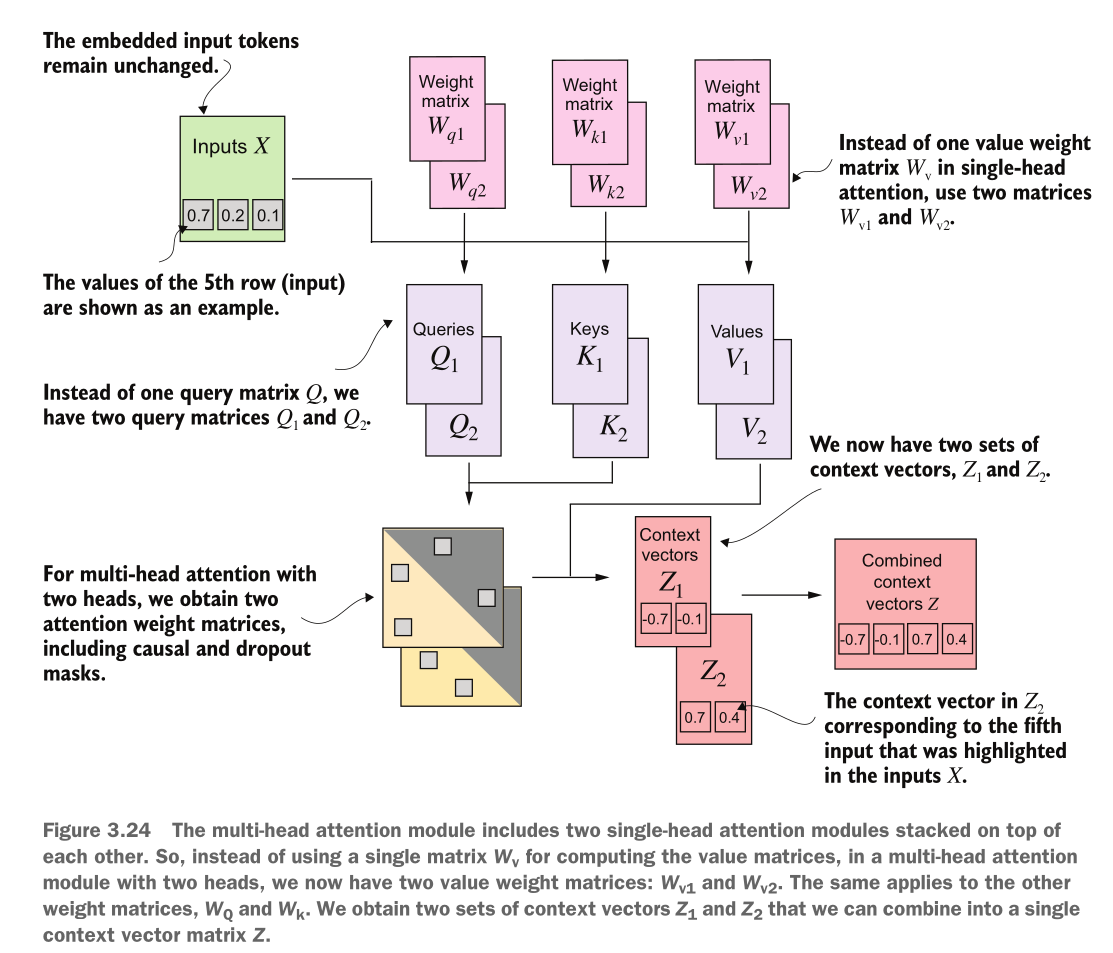

In [50]:
Image('./Screenshot from 2025-05-26 14-09-33.png')

#### As it was mentioned before the, the main idea begin a multi-head attention mechanism is to run the attention mechanism multiple times (in parallel) with different, learned linear projections. In code, we can achieve this by implementing a sim- ple MultiHeadAttentionWrapper class that stacks multiple instances of our previously implemented CausalAttention module.

In [52]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)]
        )
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [53]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        
        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec